Using 2 binary slack variables per trip
Quadratic program created with binary slack variables:
Number of variables: 14


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-09 19:43:04,366: Default instance not set. Searching all available instances.


Using backend: ibm_pittsburgh
Pending jobs: 4
Running QAOA on IBM Quantum hardware with pass_manager...


base_primitive._get_mode_service_backend:WARNING:2025-09-09 19:43:14,249: A backend was passed in as the mode but a session context manager is open so this job will run inside this session/batch instead of in job mode.


Iteration 1: Energy = (8200.607850000199+0j)
Iteration 2: Energy = (8200.607850000186+0j)
Iteration 3: Energy = (8200.607850000193+0j)
Iteration 4: Energy = (8200.607850000199+0j)
Iteration 5: Energy = (8200.607850000202+0j)
Iteration 6: Energy = (8200.60785000019+0j)
Iteration 7: Energy = (8200.607850000199+0j)
Iteration 8: Energy = (8200.607850000191+0j)
Iteration 9: Energy = (8200.607850000193+0j)
Iteration 10: Energy = (8200.607850000193+0j)
Iteration 11: Energy = (8200.607850000173+0j)
Iteration 12: Energy = (8200.607850000197+0j)
Iteration 13: Energy = (8200.607850000193+0j)
Iteration 14: Energy = (8200.607850000184+0j)
Iteration 15: Energy = (8200.607850000186+0j)
Iteration 16: Energy = (8200.60785000019+0j)
Iteration 17: Energy = (8200.607850000188+0j)
Iteration 18: Energy = (8200.607850000186+0j)
Iteration 19: Energy = (8200.607850000188+0j)
Iteration 20: Energy = (8200.607850000171+0j)
Iteration 21: Energy = (8200.607850000173+0j)
Iteration 22: Energy = (8200.607850000191+0j)

/usr/local/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


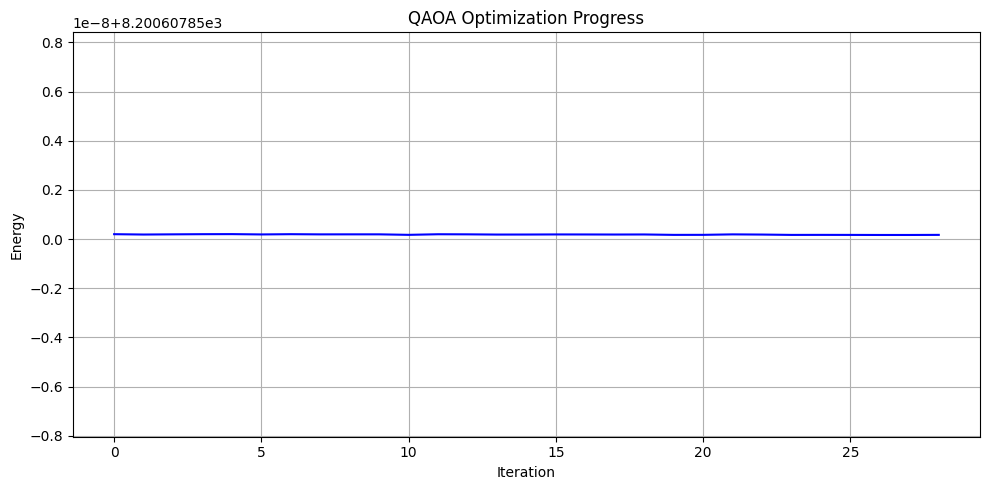

In [ ]:
# -------------------------
# QAOA with assignment formulation and binary slack variables
# Running on IBM Quantum Hardware with pass_manager
# -------------------------
import time
import math
import itertools
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from math import isfinite
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler

# -------------------------
# Problem data
# -------------------------
data = {
  "problem_description": {"constraints": {"stops_per_trip": 3}},
  "locations": {
    "hospital": {"name":"Central Hospital","coordinates":{"latitude":29.99512653425452,"longitude":31.68462840171934}},
    "patients":[
      {"id":"DT","coordinates":{"latitude":30.000417586266437,"longitude":31.73960813272627}},
      {"id":"GR","coordinates":{"latitude":30.011344405285193,"longitude":31.747827362371993}},
      {"id":"R2","coordinates":{"latitude":30.030388325206854,"longitude":31.669231198639675}},
      {"id":"R3_2","coordinates":{"latitude":30.030940768851426,"longitude":31.688371339937028}},
      {"id":"IT","coordinates":{"latitude":30.01285635906825,"longitude":31.693811715848444}}
    ]
  }
}

hospital = data["locations"]["hospital"]["coordinates"]
patients = data["locations"]["patients"]
ids = [p["id"] for p in patients]
coord_map = {"H": (hospital["latitude"], hospital["longitude"])}
for p in patients:
    coord_map[p["id"]] = (p["coordinates"]["latitude"], p["coordinates"]["longitude"])

# -------------------------
# Distance matrix (using provided data)
# -------------------------
distance_dict = {
    'H': {'H': 0.0, 'DT': 8.6285, 'GR': 11.4958, 'R2': 9.4454, 'R3_2': 10.8524, 'IT': 9.6724},
    'DT': {'H': 14.1936, 'DT': 0.0, 'GR': 2.3608, 'R2': 10.922, 'R3_2': 9.238, 'IT': 9.4305},
    'GR': {'H': 17.7848, 'DT': 7.7452, 'GR': 0.0, 'R2': 11.8083, 'R3_2': 10.1243, 'IT': 10.478},
    'R2': {'H': 11.8644, 'DT': 19.6719, 'GR': 15.6608, 'R2': 0.0, 'R3_2': 11.5718, 'IT': 11.5385},
    'R3_2': {'H': 7.3427, 'DT': 12.1719, 'GR': 10.0531, 'R2': 4.0711, 'R3_2': 0.0, 'IT': 5.9308},
    'IT': {'H': 9.2692, 'DT': 9.3984, 'GR': 12.2657, 'R2': 7.318, 'R3_2': 8.725, 'IT': 0.0}
}

# -------------------------
# Problem parameters
# -------------------------
n_trips = 2
max_stops = data["problem_description"]["constraints"]["stops_per_trip"]
patients = ids
hospital_id = "H"

# -------------------------
# Build QuadraticProgram with assignment formulation and binary slack variables
# -------------------------
qp = QuadraticProgram()

# Create binary variables for each patient-trip assignment
for p in patients:
    for t in range(1, n_trips + 1):
        qp.binary_var(name=f"x_{p}_{t}")

# Create binary slack variables for capacity constraints
slack_bits_per_trip = math.ceil(math.log2(max_stops + 1))
print(f"Using {slack_bits_per_trip} binary slack variables per trip")

for t in range(1, n_trips + 1):
    for i in range(slack_bits_per_trip):
        qp.binary_var(name=f"s_{t}_{i}")

# Objective function: minimize total distance
linear_terms = {}
for p in patients:
    for t in range(1, n_trips + 1):
        var_name = f"x_{p}_{t}"
        linear_terms[var_name] = distance_dict[hospital_id][p] + distance_dict[p][hospital_id]

# Quadratic terms: distances between patients in the same trip
quadratic_terms = {}
for t in range(1, n_trips + 1):
    for i, p1 in enumerate(patients):
        for j, p2 in enumerate(patients):
            if i < j:
                var1 = f"x_{p1}_{t}"
                var2 = f"x_{p2}_{t}"
                quadratic_terms[(var1, var2)] = distance_dict[p1][p2] + distance_dict[p2][p1]

# Set the objective
qp.minimize(linear=linear_terms, quadratic=quadratic_terms)

# Constraints
for p in patients:
    vars_for_patient = [f"x_{p}_{t}" for t in range(1, n_trips + 1)]
    coeffs = {var: 1 for var in vars_for_patient}
    qp.linear_constraint(linear=coeffs, sense='==', rhs=1, name=f"assign_{p}")

for t in range(1, n_trips + 1):
    vars_for_trip = [f"x_{p}_{t}" for p in patients]
    slack_vars = [f"s_{t}_{i}" for i in range(slack_bits_per_trip)]

    coeffs = {var: 1 for var in vars_for_trip}
    for i, slack_var in enumerate(slack_vars):
        coeffs[slack_var] = 2**i

    qp.linear_constraint(linear=coeffs, sense='==', rhs=max_stops, name=f"capacity_{t}")

print("Quadratic program created with binary slack variables:")
print(f"Number of variables: {qp.get_num_vars()}")

# -------------------------
# Setup for IBM Quantum Hardware with pass_manager
# -------------------------
# Initialize IBM Quantum account
try:
    service = QiskitRuntimeService()
    # Get the least busy backend with enough qubits
    backends = service.backends(
        simulator=False, 
        operational=True, 
        min_num_qubits=14
    )
    
    # Sort by least busy
    backends_sorted = sorted(backends, key=lambda x: x.status().pending_jobs)
    backend = backends_sorted[0]
    print(f"Using backend: {backend.name}")
    print(f"Pending jobs: {backend.status().pending_jobs}")
    
    # Create a pass manager for the backend
    # Use optimization_level=1 to reduce circuit depth while maintaining hardware compatibility
    target = backend.target
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    
except Exception as e:
    print(f"Error accessing IBM Quantum: {e}")
    print("Falling back to simulator")
    from qiskit_aer import AerSimulator
    backend = AerSimulator()
    # Create a pass manager for the simulator
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

# -------------------------
# Configure QAOA for hardware with pass_manager
# -------------------------
# Track optimization progress
loss_history = []

def callback(eval_count, parameters, mean, std):
    loss_history.append(mean)
    print(f"Iteration {eval_count}: Energy = {mean}")

# Use COBYLA optimizer
optimizer = COBYLA(maxiter=50)

# Configure QAOA with fewer repetitions to reduce circuit depth
reps = 1


# -------------------------
# Solve using Qiskit Runtime with pass_manager
# -------------------------
print("Running QAOA on IBM Quantum hardware with pass_manager...")
t0 = time.time()

try:
    with Session(backend=backend) as session:
        # Create a QAOA instance with pass_manager
        qaoa = QAOA(
            sampler=Sampler(mode=backend),
            optimizer=optimizer,
            reps=reps,
            initial_point=[0.1, 0.1],  # Good starting parameters
            callback=callback,
            pass_manager=pm  # Add pass_manager to handle transpilation
        )
        
        # Create optimizer and solve
        meo = MinimumEigenOptimizer(qaoa)
        result = meo.solve(qp)
        
except Exception as e:
    print(f"Error with Qiskit Runtime: {e}")
    print("Falling back to local execution with pass_manager")
    
    # Fallback to local execution
    from qiskit_aer.primitives import Sampler as AerSampler
    
    qaoa = QAOA(
        sampler=AerSampler(),
        optimizer=optimizer,
        reps=reps,
        initial_point=[0.1, 0.1],
        callback=callback,
        pass_manager=pm  # Use pass_manager for local execution too
    )
    
    meo = MinimumEigenOptimizer(qaoa)
    result = meo.solve(qp)

t1 = time.time()
elapsed = t1 - t0

print(f"Finished in {elapsed:.3f} s. Status: {result.status}")
print(f"QuadraticProgram objective (raw): {result.fval:.6f}")

# -------------------------
# Extract and interpret solution
# -------------------------
print("\nSolution interpretation:")
print("Variable values:")
for var_name, value in result.variables_dict.items():
    print(f"  {var_name}: {value}")

# Extract which patients are assigned to which trips
assignments = {}
for t in range(1, n_trips + 1):
    assignments[t] = []
    for p in patients:
        var_name = f"x_{p}_{t}"
        if var_name in result.variables_dict and abs(result.variables_dict[var_name] - 1) < 1e-6:
            assignments[t].append(p)

# Extract and decode binary slack variables
slack_values = {}
for t in range(1, n_trips + 1):
    slack_binary = 0
    for i in range(slack_bits_per_trip):
        slack_var = f"s_{t}_{i}"
        if slack_var in result.variables_dict and abs(result.variables_dict[slack_var] - 1) < 1e-6:
            slack_binary += 2**i
    slack_values[t] = slack_binary
    print(f"Trip {t} slack (binary decoded): {slack_binary}")

print("\nPatient assignments:")
for t, patients_in_trip in assignments.items():
    capacity_used = len(patients_in_trip)
    slack_value = slack_values.get(t, 0)
    print(f"Trip {t}: {patients_in_trip} (Capacity used: {capacity_used}/3, Slack: {slack_value})")
    print(f"  Constraint check: {capacity_used} + {slack_value} = {capacity_used + slack_value} (should be 3)")

# Calculate actual distance for each trip
total_distance = 0
trip_details = {}
for t, patients_in_trip in assignments.items():
    if not patients_in_trip:
        continue

    # Find optimal permutation for this trip
    best_perm = None
    best_distance = float('inf')

    for perm in itertools.permutations(patients_in_trip):
        dist = distance_dict[hospital_id][perm[0]]
        for i in range(len(perm) - 1):
            dist += distance_dict[perm[i]][perm[i+1]]
        dist += distance_dict[perm[-1]][hospital_id]

        if dist < best_distance:
            best_distance = dist
            best_perm = perm

    total_distance += best_distance
    trip_details[t] = {
        'patients': best_perm,
        'distance': best_distance
    }

    print(f"Trip {t} optimal route: H -> {' -> '.join(best_perm)} -> H, Distance: {best_distance:.4f} km")

print(f"\nTotal distance: {total_distance:.4f} km")

# Check constraint satisfaction
constraints_satisfied = True
print("\nConstraint satisfaction check:")

# Check patient assignment constraints
for p in patients:
    assignment_count = 0
    for t in range(1, n_trips + 1):
        var_name = f"x_{p}_{t}"
        if var_name in result.variables_dict and abs(result.variables_dict[var_name] - 1) < 1e-6:
            assignment_count += 1
    print(f"Patient {p} assigned to {assignment_count} trips: {'OK' if assignment_count == 1 else 'VIOLATION'}")
    if assignment_count != 1:
        constraints_satisfied = False

# Check capacity constraints with binary slack
for t in range(1, n_trips + 1):
    patient_count = 0
    for p in patients:
        var_name = f"x_{p}_{t}"
        if var_name in result.variables_dict and abs(result.variables_dict[var_name] - 1) < 1e-6:
            patient_count += 1

    slack_binary = 0
    for i in range(slack_bits_per_trip):
        slack_var = f"s_{t}_{i}"
        if slack_var in result.variables_dict and abs(result.variables_dict[slack_var] - 1) < 1e-6:
            slack_binary += 2**i

    constraint_value = patient_count + slack_binary
    print(f"Trip {t}: {patient_count} patients + {slack_binary} slack = {constraint_value}: {'OK' if constraint_value == max_stops else 'VIOLATION'}")
    if constraint_value != max_stops:
        constraints_satisfied = False

print(f"\nAll constraints satisfied: {constraints_satisfied}")

# -------------------------
# Plot loss curve
# -------------------------
if loss_history:
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, 'b-', linewidth=1.5)
    plt.title('QAOA Optimization Progress')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('qaoa_loss_curve_hardware.png')
    plt.show()
else:
    print("No loss history recorded")